In [1]:
%load_ext autoreload
%autoreload 2

In [137]:
import pandas as pd
import geopandas as gpd
import sampers
import mscthesis
import plotly.graph_objects as pgo
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
visits = pd.read_csv('./../../dbs/sweden/visits-song.csv').set_index('userid')

In [77]:
visits = gpd.GeoDataFrame(
    visits,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(visits.longitude, visits.latitude),
)

In [124]:
sampers_zones = sampers.read_shp(sampers.shps['east'])
sampers_zones.shape

(3038, 5)

In [121]:
visits = visits.to_crs(sampers_zones.crs)

In [122]:
regional_visits = visits[visits.kind == 'region']
user_regions = regional_visits.groupby(['userid', 'region']).head(1)


(2019511, 7)

In [123]:
user_zones = gpd.overlay(user_regions.reset_index(), sampers_zones, how='intersection')
user_zones = user_zones[['userid', 'region', 'zone']]

In [125]:
regional_visitsx = user_zones.merge(regional_visits, on=['userid', 'region']).set_index('userid')
regional_visitsx.shape

(1921244, 8)

In [126]:
twitter_trips = mscthesis.visit_gaps(regional_visitsx[['region', 'zone']])

In [142]:
twitter_trips

,region_origin,zone_origin,region_destination,zone_destination
userid,,,,
5616,5,716330,5,716330
5616,5,716330,5,716330
5616,5,716330,5,716330
5616,5,716330,5,716330
5616,5,716330,5,716330
...,...,...,...,...
2771186153,39,701331,16,701331
2771186153,16,701331,45,701331
2771186153,45,701331,38,701331


In [155]:
twitter_odm = twitter_trips.groupby(['zone_origin', 'zone_destination']).size()

In [156]:
twitter_odm.sum()

1917377

In [130]:
sampers_odm = sampers.read_odm(sampers.odms['east'])
# drop unknown zones
#sampers_odm = sampers_odm[(sampers_odm['ozone'] > 10000) & (sampers_odm['dzone'] > 10000)]
sampers_odm = sampers_odm.set_index(['ozone', 'dzone'])['total']

In [157]:
twitter_odm = twitter_odm.reindex(sampers_odm.index, fill_value=0)

In [160]:
twitter_odm.describe()

count    9.253764e+06
mean     2.066068e-01
std      8.729773e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.943750e+05
dtype: float64

In [70]:
def logprobscale(original_scale=px.colors.sequential.Viridis):
    return list(zip(np.concatenate(([0], 1/(2**np.arange(len(original_scale)-2,0, step=-1)), [1])), original_scale))

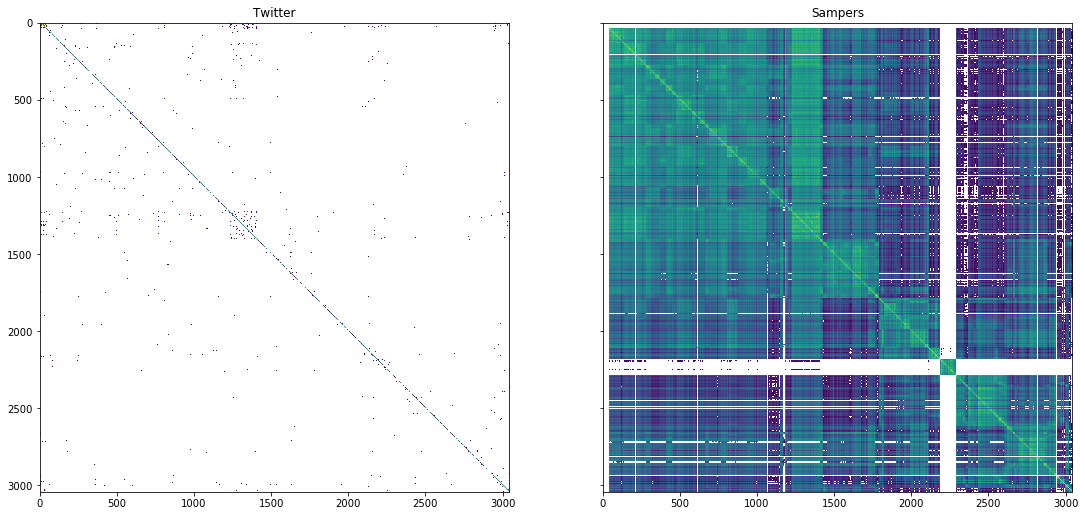

In [159]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(twitter_odm.unstack().values, norm = mpl.colors.LogNorm())
ax2.imshow(sampers_odm.unstack().values, norm = mpl.colors.LogNorm())
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()